In [88]:
import os
import json
import pandas as pd
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
import pickle
from pyitlib import discrete_random_variable as drv

In [20]:
BENCHMARKS = {
     'nasbench101': ['cifar10'],
    'nasbench201': ['cifar10', 'cifar100', 'ImageNet16-120'],
    'nasbench301': ['cifar10'],
    'transbench101_micro': ['jigsaw', 'class_scene', 'class_object', 'autoencoder', 'normal', 'room_layout', 'segmentsemantic'],
    'transbench101_macro': ['jigsaw', 'class_scene', 'class_object', 'autoencoder', 'normal', 'room_layout', 'segmentsemantic']
}

LABELS = {
    'nasbench101': 'NB101',
    'nasbench201': 'NB201',
    'nasbench301': 'NB301',
    'transbench101_micro': 'TNB101_MICRO',
    'transbench101_macro': 'TNB101_MACRO',
    'cifar10': 'CF10',
    'cifar100': 'CF100',
    'ImageNet16-120': 'IMGNT',
    'jigsaw': 'JIGSAW',
    'class_scene': 'SCENE',
    'class_object': 'OBJECT',
    'autoencoder': 'AUTOENC',
    'normal': 'NORMAL',
    'room_layout': 'ROOM',
    'segmentsemantic': 'SEGMENT',
}

START_SEED=9000
END_SEED=9005

In [278]:
def get_all_files(root_folder='../run/results/correlation', filename='scores.json'):
    all_files = []
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file.endswith(filename):
                all_files.append(os.path.join(root, file))

    return all_files


def get_scores_as_list_of_dict(files):
    data = []

    for file in files:
        file_components = file.split('/')
        search_space, dataset, predictor, seed = file_components[-5], file_components[-4], file_components[-3], file_components[-2]
        
        with open(file, 'r') as f:
            scores = json.load(f)[1]

        record = {
            'search_space': search_space,
            'dataset': dataset,
            'predictor': predictor,
            'seed': seed,
            'kendalltau': scores['kendalltau'],
            'pearson': scores['pearson'],
            'spearman': scores['spearman'],
            'preds': scores['full_testpred'],
            'ground_truth': scores['full_ytest'],
        }

        data.append(record)

    return data


def make_df(files):
    data = get_scores_as_list_of_dict(files)
    df = pd.DataFrame(data)
    return df

def make_clean_df(preds_to_drop=None):
    files = get_all_files()
    print(files[0])
    df = make_df(files)
    return df

def discretize(values, bins=10):
    bin_edges = np.histogram_bin_edges(values, bins=bins)
    bin_edges[-1] += 1
    return np.digitize(values, bin_edges)



In [279]:
def cond_ent_k_predictors(df, predictors):
    ent_arr = []
    for seed in [str(i) for i in range(START_SEED, END_SEED)]:
        df_ = df[(df['seed'] == seed)]
        preds = []
        for predictor in predictors:
            preds.append(np.array(df_[df_['predictor'] == predictor]['preds'].to_list()[0]))

        truths = np.array(df_[df_['predictor'] == predictors[0]]['ground_truth'].to_list()[0])
        n_bins = int(np.round(1+3.322*np.log(len(preds[0]))))

        preds_disc = []
        for pred in preds:
            preds_disc.append(discretize(pred, bins=n_bins))

        truths_disc = discretize(truths, bins=n_bins)

        all_joint_ent = drv.entropy_joint(np.vstack([preds_disc, truths_disc]))
        preds_ent = drv.entropy_joint(preds_disc)
        cond_ent = all_joint_ent - preds_ent
        ent_arr.append(cond_ent)
    
    
    return np.array(ent_arr).mean()
    

In [280]:
def cond_ent_single_predictor(df, predictor):
    ent_arr = []
    for seed in [str(i) for i in range(START_SEED, END_SEED)]:
        df_ = df[(df['seed'] == seed)]
        preds = np.array(df_[df_['predictor'] == predictor]['preds'].to_list()[0])
        truths = np.array(df_[df_['predictor'] == predictor]['ground_truth'].to_list()[0])
        n_bins = int(np.round(1+3.322*np.log(len(preds))))

        preds_disc = discretize(preds, bins=n_bins) 
        truths_disc = discretize(truths, bins=n_bins)

        cond_ent = drv.entropy_conditional(truths_disc, preds_disc)
        ent_arr.append(cond_ent)
    
    return np.array(ent_arr).mean()


In [281]:
def select_best_predictor(df, final_list, candidate_list):

    if len(final_list) == 0:
        score_list = [cond_ent_single_predictor(df, candidate) for candidate in candidate_list]

    else:
        score_list = [cond_ent_k_predictors(df, final_list + [candidate]) for candidate in candidate_list]
    
    score_dict = dict(zip(candidate_list, score_list))
    best_predictor = sorted(score_dict.items(), key=lambda kv:kv[1])[0][0]
    final_list.append(best_predictor)
    candidate_list.remove(best_predictor)

    return final_list, candidate_list


In [282]:
import itertools
#find k best ZC proxies minimizing conditional entropy 
def find_k_predictors(df, k, predictors, mode='maximum'):
    assert mode in ['maximum', 'greedy', 'random']
    assert k <= len(predictors)
        
    if mode == 'random':
        return np.random.choice(predictors, size=k, replace=False)
    elif mode == 'maximum':
        #compute all combinations of k predictors, choose largest
        min_ent = np.inf
        best_k = None
        for comb in itertools.combinations(predictors, k):
            score = cond_ent_k_predictors(df, np.array(comb))
            if score < min_ent:
                min_ent = score
                best_k = comb
        return np.array(best_k)
    else:
        #iteratively add to the list
        final_k = []
        candidate_list = predictors.tolist()
        while len(final_k) < k:
            final_k, candidate_list = select_best_predictor(df, final_k, candidate_list)
        return np.array(final_k)  
        
    

In [164]:
print(df['predictor'].unique())

['fisher' 'grad_norm' 'plain' 'snip' 'zen' 'nwot' 'flops' 'jacov' 'params'
 'grasp' 'l2_norm' 'synflow' 'epe_nas']


# Get lists of proxies (do not run these)

In [157]:
def get_proxy_lists(df):
    
    greedy_proxy_list = []
    for k in range(1,len(df['predictor'].unique())+1):
        lst = find_k_predictors( df, k, df['predictor'].unique(), 'greedy' )
        greedy_proxy_list.append(lst)

    maximize_proxy_list = []
    for k in range(1,len(df['predictor'].unique())+1):
        lst = find_k_predictors( df, k, df['predictor'].unique(), 'maximum' )
        maximize_proxy_list.append(lst)
    

    random_proxy_list = []
    for k in range(1,len(df['predictor'].unique())+1):
        lst = find_k_predictors( df, k, df['predictor'].unique(), 'random' )
        random_proxy_list.append(lst)

    return greedy_proxy_list, maximize_proxy_list, random_proxy_list

In [ ]:
proxy_list_dict = {}


In [210]:
df = make_clean_df()
for bench in ['nasbench301']:
    print(bench)
    proxy_list_dict[bench] = {}
    for dataset in BENCHMARKS[bench]:
        proxy_list_dict[bench][dataset] = {}
        print(dataset)
        df_specific = df[(df['search_space'] == bench) & (df['dataset'] == dataset)]
        greedy_lst, maximize_lst, random_lst  = get_proxy_lists(df_specific)
        proxy_list_dict[bench][dataset]['greedy'] = greedy_lst
        proxy_list_dict[bench][dataset]['maximize'] = maximize_lst
        proxy_list_dict[bench][dataset]['random'] = random_lst


        

../run/results/correlation/transbench101_micro/jigsaw/fisher/9000/scores.json
nasbench301
cifar10


In [82]:
bench = 'transbench101_macro'
dataset = 'room_layout'
df_specific = df[(df['search_space'] == 'transbench101_macro') & (df['dataset'] == dataset)]
greedy_lst, maximize_lst, random_lst  = get_proxy_lists(df_specific)
proxy_list_dict[bench][dataset] = {}
proxy_list_dict[bench][dataset]['greedy'] = greedy_lst
proxy_list_dict[bench][dataset]['maximize'] = maximize_lst
proxy_list_dict[bench][dataset]['random'] = random_lst

In [83]:
bench = 'transbench101_macro'
dataset = 'segmentsemantic'
df_specific = df[(df['search_space'] == 'transbench101_macro') & (df['dataset'] == dataset)]
greedy_lst, maximize_lst, random_lst  = get_proxy_lists(df_specific)
proxy_list_dict[bench][dataset] = {}
proxy_list_dict[bench][dataset]['greedy'] = greedy_lst
proxy_list_dict[bench][dataset]['maximize'] = maximize_lst
proxy_list_dict[bench][dataset]['random'] = random_lst

In [283]:
with open('proxy_list.pkl', 'wb') as f:
    pickle.dump(proxy_list_dict, f)

In [284]:
with open('proxy_list.pkl', 'rb') as f:
    pl = pickle.load(f)

# Plot entropy vs num proxies

In [96]:
def calculate_entropy_from_proxy_list(df, predictor_lists):
    entropy_list = []
    for item in predictor_lists:
        if len(item) == 1:
            entropy = cond_ent_single_predictor(df, item[0])
        else:
            entropy = cond_ent_k_predictors(df, item)
        entropy_list.append(entropy)
    if len(entropy_list) == 12:
        assert len(df_['predictor'].unique()) == 13
        #print('adding full proxy usage')
        full_entropy = cond_ent_k_predictors(df, df_['predictor'].unique())
        entropy_list.append(full_entropy)
    return np.array(entropy_list)
    

In [221]:
def get_three_entropy_lists(benchmark, dataset):
    df = make_clean_df()
    df_ = df[(df['search_space'] == benchmark) & (df['dataset'] == dataset)]

    #get greedy list 
    greedy_proxy_list = proxy_list_dict[benchmark][dataset]['greedy']
    greedy_ent = calculate_entropy_from_proxy_list(df_, greedy_proxy_list)
    
    #get maximize list 
    maximize_proxy_list = proxy_list_dict[benchmark][dataset]['maximize']
    maximize_ent = calculate_entropy_from_proxy_list(df_, maximize_proxy_list)
    
   #get random trials 
    random_proxy_list = []
    for _ in range(100):
        proxy_list = []
        for k in range(1,len(df_.predictor.unique())+1):
            lst = find_k_predictors( df_, k, df_['predictor'].unique(), 'random' )
            proxy_list.append(lst)
        random_proxy_list.append(proxy_list)
    entropy_trials = np.array([calculate_entropy_from_proxy_list(df_, proxy_list) for proxy_list in random_proxy_list])
    

    return entropy_trials, greedy_ent, maximize_ent
  
    


In [274]:
def plot(arr1, arr2, arr3, title, xlabel, ylabel, figsize=(6, 4), savedir='.', savetitle='proxy_plot'):
    x = arr1
    x_mean = np.mean(x, axis=0)
    x_std = np.std(x, axis=0)
    
    plt.figure(figsize=figsize, dpi=200)
    plt.title(title, fontsize=20)
    plt.plot(x_mean, label='random')
    plt.fill_between(range(len(x_mean)), x_mean-x_std, x_mean+x_std, alpha=0.6)
    
    plt.plot(arr2, label='greedy')
    plt.plot(arr3, label='maximize')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #plt.ylim(0,3)
    plt.grid(True)
    plt.legend()
    plt.xticks(np.arange(len(x_mean)), np.arange(1, len(x_mean)+1))
    if savedir != '.':
        os.makedirs(savedir, exist_ok=True)
    plt.savefig('{}/{}.pdf'.format(savedir, savetitle), bbox_inches='tight')    




In [258]:
entropy_trials, greedy_ent, maximize_ent = get_three_entropy_lists('nasbench301', 'cifar10' )


../run/results/correlation/transbench101_micro/jigsaw/fisher/9000/scores.json


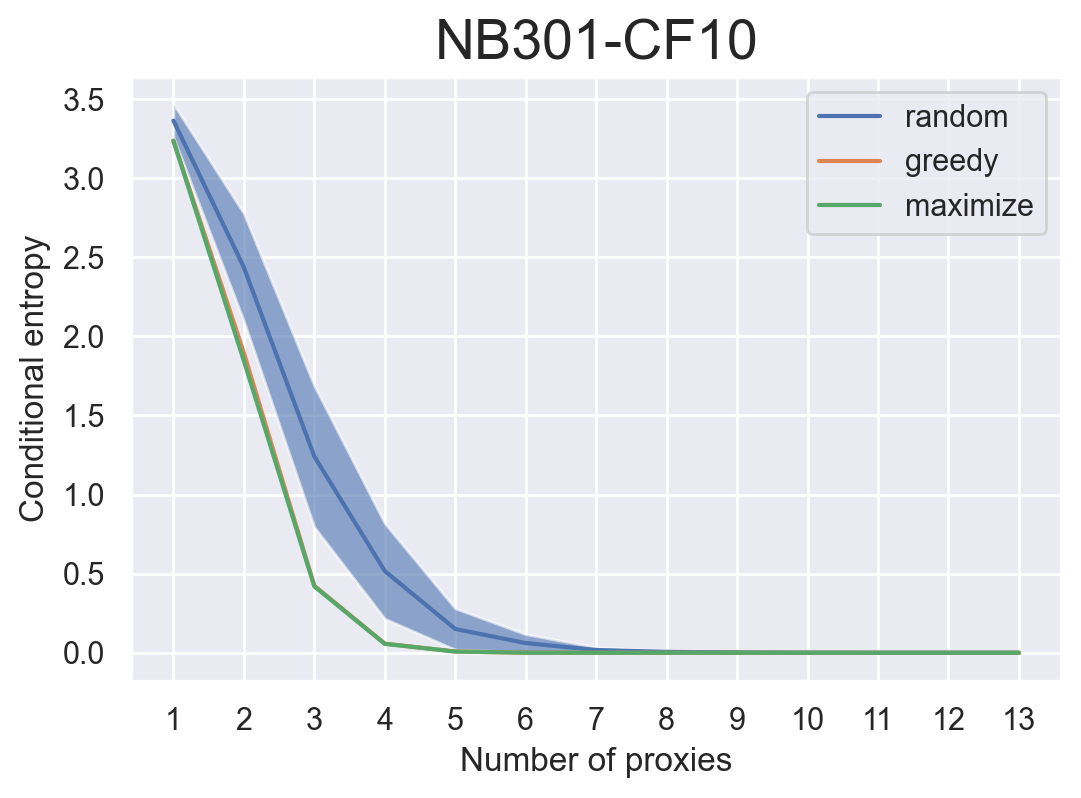

In [275]:
plot(entropy_trials, greedy_ent, maximize_ent, 'NB301-CF10', 'Number of proxies', 'Conditional entropy', savedir='entropy_vs_proxy', 
    savetitle='entropy_nb301_cf10')

In [244]:
entropy_trials_101, greedy_ent_101, maximize_ent_101 = get_three_entropy_lists('nasbench101', 'cifar10' )


../run/results/correlation/transbench101_micro/jigsaw/fisher/9000/scores.json


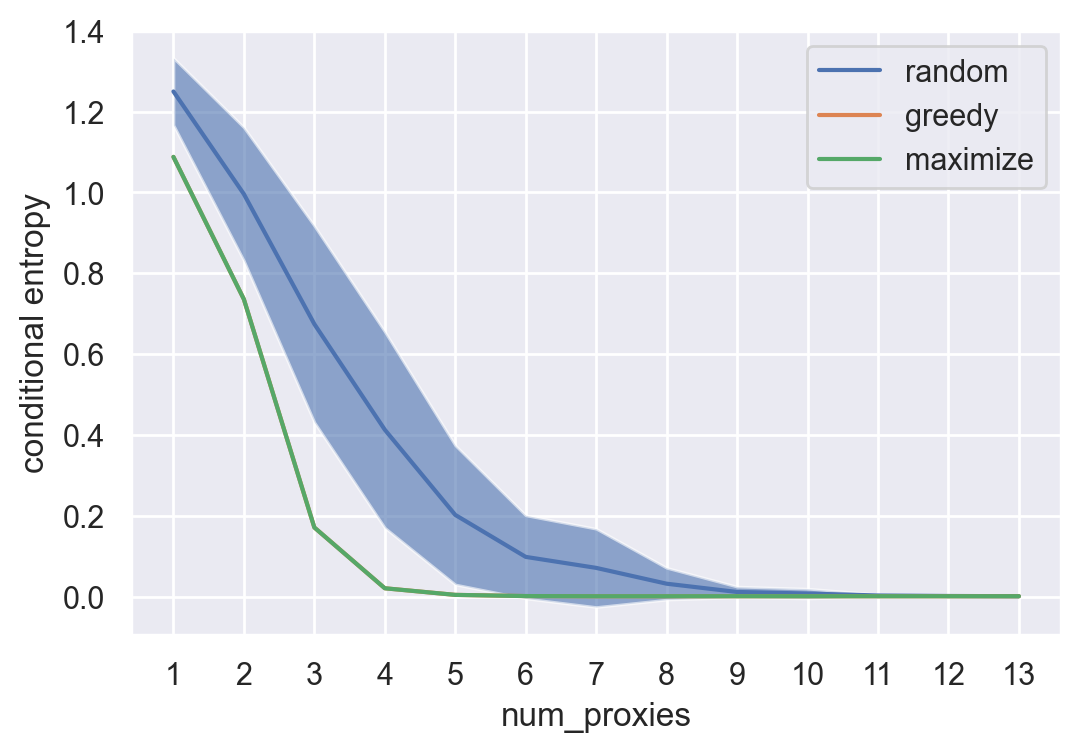

In [245]:
plot(entropy_trials_101, greedy_ent_101, maximize_ent_101, 'entropy', 'num_proxies', 'conditional entropy')

In [224]:
entropy_trials_tnb, greedy_ent_tnb, maximize_ent_tnb = get_three_entropy_lists('transbench101_micro', 'jigsaw' )


../run/results/correlation/transbench101_micro/jigsaw/fisher/9000/scores.json


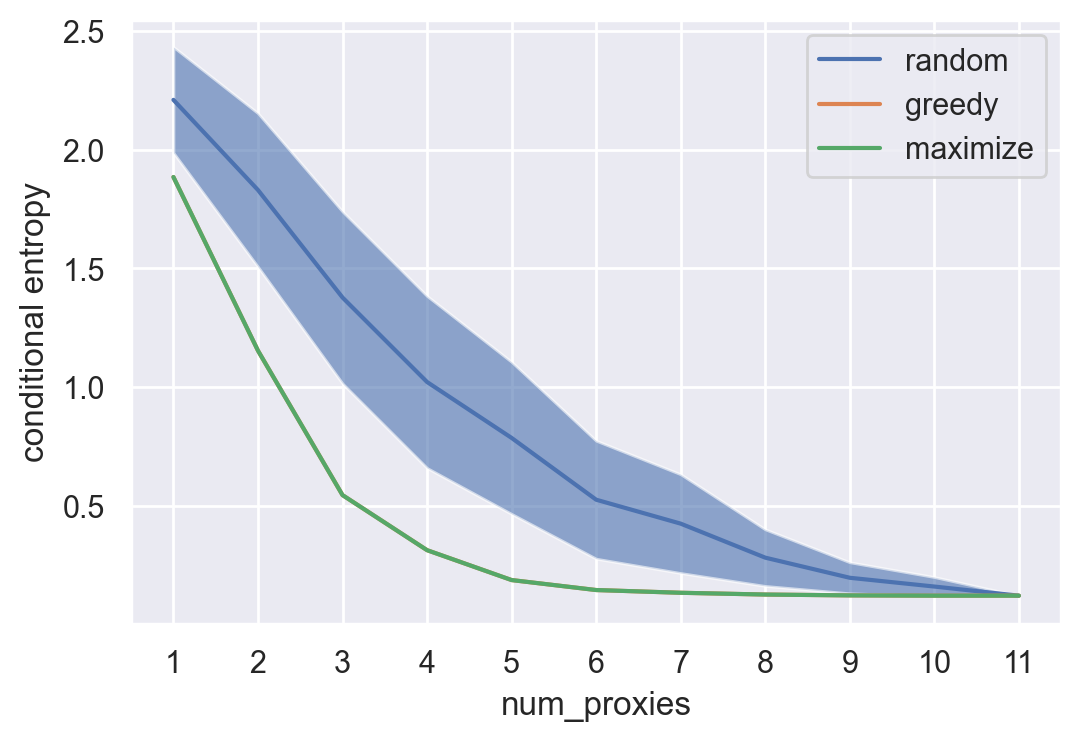

In [225]:
plot(entropy_trials_tnb, greedy_ent_tnb, maximize_ent_tnb, 'entropy', 'num_proxies', 'conditional entropy')

In [222]:
entropy_trials_201, greedy_ent_201, maximize_ent_201 = get_three_entropy_lists('nasbench201', 'cifar100' )


../run/results/correlation/transbench101_micro/jigsaw/fisher/9000/scores.json


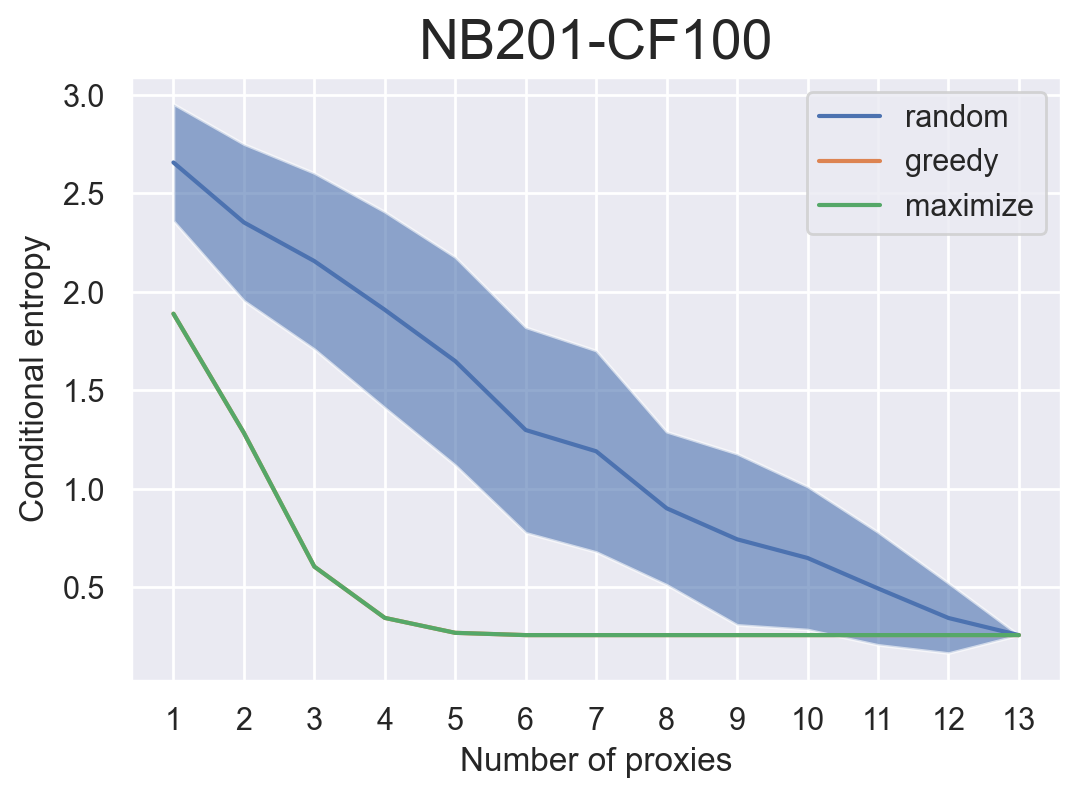

In [276]:
plot(entropy_trials_201, greedy_ent_201, maximize_ent_201, 'NB201-CF100', 'Number of proxies', 'Conditional entropy',
    savedir='entropy_vs_proxy', 
    savetitle='entropy_nb201_cf100')

In [226]:
entropy_trials_tnb_macro, greedy_ent_tnb_macro, maximize_ent_tnb_macro = get_three_entropy_lists('transbench101_macro', 'jigsaw' )


../run/results/correlation/transbench101_micro/jigsaw/fisher/9000/scores.json


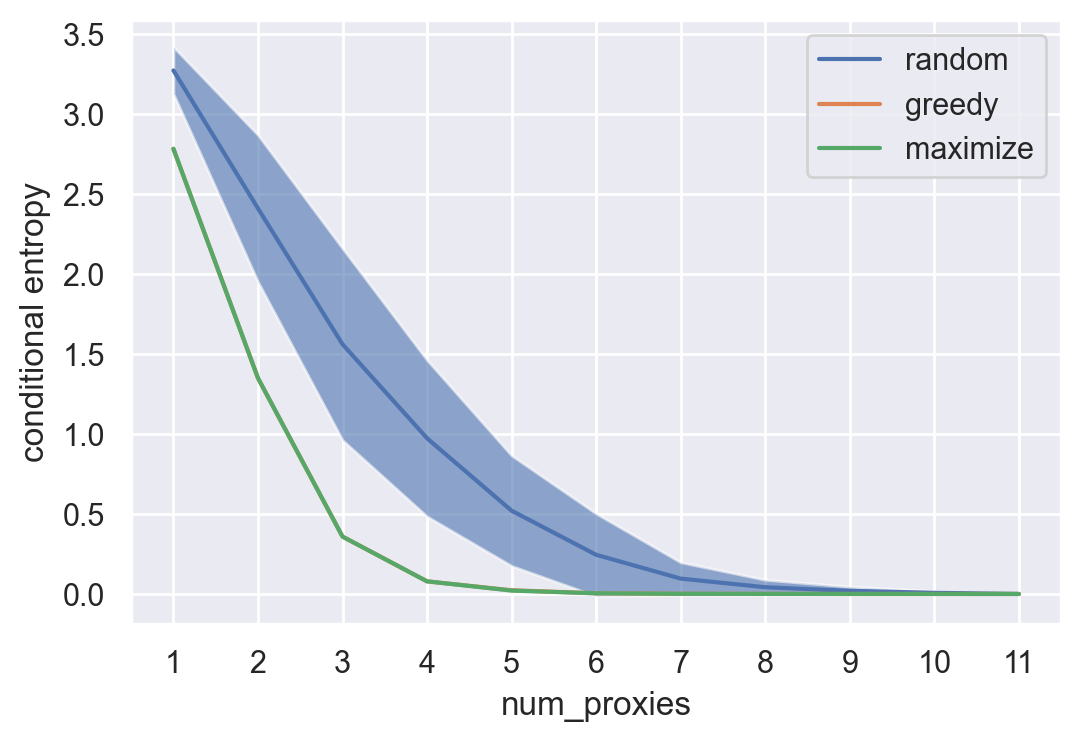

In [228]:
plot(entropy_trials_tnb_macro, greedy_ent_tnb_macro, maximize_ent_tnb_macro, 'entropy', 'num_proxies', 'conditional entropy')

../run/results/correlation/transbench101_micro/jigsaw/fisher/9000/scores.json


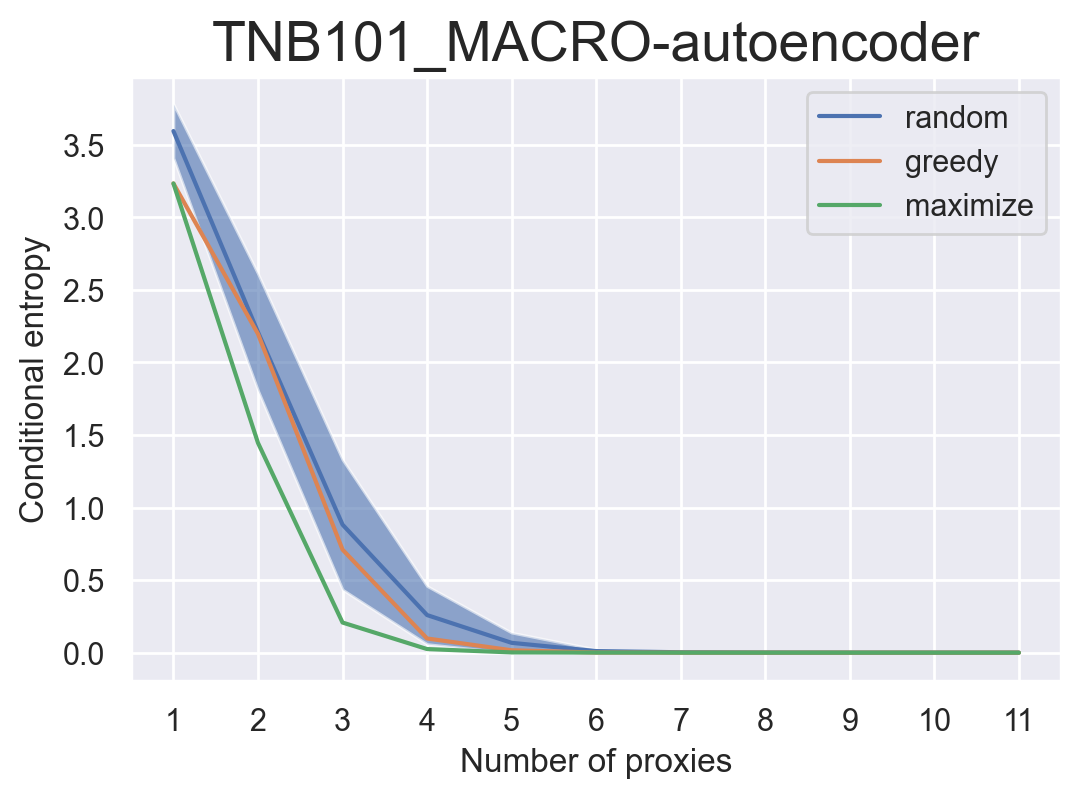

In [287]:
entropy_trials_tnb_macro_auto, greedy_ent_tnb_macro_auto, maximize_ent_tnb_macro_auto = get_three_entropy_lists('transbench101_macro', 'autoencoder' )


plot(entropy_trials_tnb_macro_auto, greedy_ent_tnb_macro_auto, maximize_ent_tnb_macro_auto, 'TNB101_MACRO-autoencoder', 'Number of proxies', 'Conditional entropy',
    savedir='entropy_vs_proxy', 
    savetitle='entropy_tnb101macro_autoencoder')

### check diff between maximize and greedy

In [233]:
import collections

In [243]:
for bench in BENCHMARKS:
    for dataset in BENCHMARKS[bench]:
        greedy_list = proxy_list_dict[bench][dataset]['greedy']
        maximize_list = proxy_list_dict[bench][dataset]['maximize']
        for i in range(len(greedy_list)):
            if collections.Counter(greedy_list[i]) != collections.Counter(maximize_list[i]):
                #print(greedy_list[i])
                #print(maximize_list[i])
                print(bench, dataset)
                

nasbench101 cifar10
nasbench101 cifar10
nasbench101 cifar10
nasbench101 cifar10
nasbench101 cifar10
nasbench101 cifar10
nasbench201 cifar10
nasbench201 cifar10
nasbench201 cifar100
nasbench201 cifar100
nasbench201 cifar100
nasbench201 ImageNet16-120
nasbench201 ImageNet16-120
nasbench201 ImageNet16-120
nasbench201 ImageNet16-120
nasbench301 cifar10
nasbench301 cifar10
nasbench301 cifar10
nasbench301 cifar10
nasbench301 cifar10
nasbench301 cifar10
nasbench301 cifar10
transbench101_micro class_scene
transbench101_micro class_object
transbench101_micro normal
transbench101_micro segmentsemantic
transbench101_micro segmentsemantic
transbench101_micro segmentsemantic
transbench101_micro segmentsemantic
transbench101_macro jigsaw
transbench101_macro jigsaw
transbench101_macro jigsaw
transbench101_macro class_scene
transbench101_macro class_scene
transbench101_macro class_scene
transbench101_macro class_scene
transbench101_macro class_scene
transbench101_macro class_scene
transbench101_macro 

In [250]:
proxy_list_dict['transbench101_macro']['autoencoder']['greedy']

[array(['flops'], dtype='<U5'),
 array(['flops', 'l2_norm'], dtype='<U7'),
 array(['flops', 'l2_norm', 'plain'], dtype='<U7'),
 array(['flops', 'l2_norm', 'plain', 'jacov'], dtype='<U7'),
 array(['flops', 'l2_norm', 'plain', 'jacov', 'grad_norm'], dtype='<U9'),
 array(['flops', 'l2_norm', 'plain', 'jacov', 'grad_norm', 'nwot'],
       dtype='<U9'),
 array(['flops', 'l2_norm', 'plain', 'jacov', 'grad_norm', 'nwot',
        'params'], dtype='<U9'),
 array(['flops', 'l2_norm', 'plain', 'jacov', 'grad_norm', 'nwot',
        'params', 'fisher'], dtype='<U9'),
 array(['flops', 'l2_norm', 'plain', 'jacov', 'grad_norm', 'nwot',
        'params', 'fisher', 'zen'], dtype='<U9'),
 array(['flops', 'l2_norm', 'plain', 'jacov', 'grad_norm', 'nwot',
        'params', 'fisher', 'zen', 'snip'], dtype='<U9'),
 array(['flops', 'l2_norm', 'plain', 'jacov', 'grad_norm', 'nwot',
        'params', 'fisher', 'zen', 'snip', 'grasp'], dtype='<U9')]

In [251]:
proxy_list_dict['transbench101_macro']['autoencoder']['maximize']

[array(['flops'], dtype='<U5'),
 array(['nwot', 'l2_norm'], dtype='<U7'),
 array(['plain', 'nwot', 'l2_norm'], dtype='<U7'),
 array(['plain', 'nwot', 'jacov', 'l2_norm'], dtype='<U7'),
 array(['grad_norm', 'plain', 'nwot', 'jacov', 'l2_norm'], dtype='<U9'),
 array(['fisher', 'plain', 'nwot', 'jacov', 'params', 'l2_norm'],
       dtype='<U7'),
 array(['fisher', 'zen', 'nwot', 'flops', 'jacov', 'params', 'l2_norm'],
       dtype='<U7'),
 array(['fisher', 'grad_norm', 'plain', 'zen', 'flops', 'jacov', 'params',
        'l2_norm'], dtype='<U9'),
 array(['fisher', 'grad_norm', 'plain', 'snip', 'nwot', 'flops', 'jacov',
        'params', 'l2_norm'], dtype='<U9'),
 array(['fisher', 'grad_norm', 'plain', 'snip', 'zen', 'nwot', 'flops',
        'jacov', 'params', 'grasp'], dtype='<U9'),
 array(['fisher', 'grad_norm', 'plain', 'snip', 'zen', 'nwot', 'flops',
        'jacov', 'params', 'grasp', 'l2_norm'], dtype='<U9')]